CS4001/4042 Assignment 1, Part B, Q3
---

Besides ensuring that your neural network performs well, it is important to be able to explain the model’s decision. **Captum** is a very handy library that helps you to do so for PyTorch models.

Many model explainability algorithms for deep learning models are available in Captum. These algorithms are often used to generate an attribution score for each feature. Features with larger scores are more ‘important’ and some algorithms also provide information about directionality (i.e. a feature with very negative attribution scores means the larger the value of that feature, the lower the value of the output).

In general, these algorithms can be grouped into two paradigms:
- **perturbation based approaches** (e.g. Feature Ablation)
- **gradient / backpropagation based approaches** (e.g. Saliency)

The former adopts a brute-force approach of removing / permuting features one by one and does not scale up well. The latter depends on gradients and they can be computed relatively quickly. But unlike how backpropagation computes gradients with respect to weights, gradients here are computed **with respect to the input**. This gives us a sense of how much a change in the input affects the model’s outputs.





---



---



In [44]:
!pip install captum

In [45]:
SEED = 42

import os

import random
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import pandas as pd

import torch
import torch.nn as nn

from captum.attr import Saliency, InputXGradient, IntegratedGradients, GradientShap, FeatureAblation

> First, load the dataset following the splits in Question B1. To keep things simple, we will **limit our analysis to numeric / continuous features only**. Drop all categorical features from the dataframes. Do not standardise the numerical features for now.



In [46]:
# TODO: Enter your code here
df = pd.read_csv('hdb_price_prediction.csv')

# year 2019 and before as training data
df_train = df[df['year'] <= 2019]
# year 2020 as validation data
df_validation = df[df['year'] == 2020]
# year 2021 as test data
df_test = df[df['year'] == 2021]

target = ['resale_price']
# ALL categorical columns are: 'month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range'
categorical_columns = ['month', 'year', 'town', 'full_address', 'nearest_stn', 'flat_model_type', 'storey_range']

# Drop columns (axis = 1) in categorical_columns
df_train = df_train.drop(categorical_columns, axis=1)
df_validation = df_validation.drop(categorical_columns, axis=1)
df_test = df_test.drop(categorical_columns, axis=1)


> Follow this tutorial to generate the plot from various model explainability algorithms (https://captum.ai/tutorials/House_Prices_Regression_Interpret).
Specifically, make the following changes:
- Use a feedforward neural network with 3 hidden layers, each having 5 neurons. Train using Adam optimiser with learning rate of 0.001.
- Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation


In [47]:
# Extract input features (X_train, X_test) from dfs
X_train = df_train.drop(target, axis=1).values
X_test = df_test.drop(target, axis=1).values

# Extract target labels (y_train, y_test) from dfs
y_train = df_train[target].values
y_test = df_test[target].values


In [48]:
# tensorize input features
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()

# tensorize target labels
y_train = torch.tensor(y_train).view(-1, 1).float()
y_test = torch.tensor(y_test).view(-1, 1).float()

tensordataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(tensordataset_train, batch_size=1024, shuffle=True)

In [49]:
# Define default hyper parameters for the model
batch_size = 1024
num_epochs = 200
learning_rate = 0.001
size_hidden = 5 #  since all 3 hidden layers have 5 neurons
output_layer = 1

In [50]:
# dataset_test = torch.utils.data.TensorDataset(X_test, y_test)
# dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

# neural network definition
class HDBPriceRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer --> first hidden layer
        self.lin1 = nn.Linear(X_train.shape[1], size_hidden)
        self.relu1 = nn.ReLU()
        # first hidden layer --> second hidden layer
        self.lin2 = nn.Linear(size_hidden, size_hidden)
        self.relu2 = nn.ReLU()
        # second hidden layer --> third hidden layer
        self.lin3 = nn.Linear(size_hidden, size_hidden)
        self.relu3 = nn.ReLU()
        # third hidden layer --> output layer
        self.lin4 = nn.Linear(size_hidden, output_layer)

    def forward(self, input):
        return self.lin4(self.relu3(self.lin3(self.relu2(self.lin2(self.relu1(self.lin1(input)))))))

model = HDBPriceRegressionModel()
# loss_function similar to B1
criterion = nn.MSELoss(reduction='sum')


In [51]:
def train(model, num_epochs = num_epochs):
    # Train using Adam optimiser with learning rate of 0.001.
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        for inputs, labels in dataloader_train:
            # forward pass
            outputs = model(inputs)
            # defining loss
            loss = criterion(outputs, labels)
            # zero the parameter gradients
            optimizer.zero_grad()
            # computing gradients
            loss.backward()
            # accumulating running loss
            running_loss += loss.item()
            # updated weights based on computed gradients
            optimizer.step()
        if epoch % 20 == 0:
            print('Epoch [%d]/[%d] running accumulative loss across all batches: %.3f' %
                  (epoch + 1, num_epochs, running_loss))
        running_loss = 0.0

def train_load_save_model(model, model_path):
    if os.path.isfile(model_path):
        # load model
        print('Loading pre-trained model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    else:
        # train model
        train(model)
        print('Finished training the model. Saving the model to the path: {}'.format(model_path))
        torch.save(model.state_dict(), model_path)

SAVED_MODEL_PATH = 'hdbpriceprediction_model.pt'
train_load_save_model(model, SAVED_MODEL_PATH)

Loading pre-trained model from: hdbpriceprediction_model.pt


In [52]:
import sklearn.metrics

model.eval()
outputs = model(X_test)
err = np.sqrt(sklearn.metrics.mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  125204.06


In [53]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation
saliency = Saliency(model) # https://captum.ai/api/saliency.html
inputxgradient = InputXGradient(model) # https://captum.ai/api/input_x_gradient.html
integratedgradients = IntegratedGradients(model)
gradientshap = GradientShap(model)
featureablation = FeatureAblation(model)

# FAQ Suggestion: Instead of using the whole X_test, you can limit the analysis to the first 1000 samples in X_test.
#                 If you do so, remember to do it for all model explainability algorithms.
num_samples = 1000
saliency_attr_test = saliency.attribute(X_test[:num_samples])
inputxgradient_attr_test = inputxgradient.attribute(X_test[:num_samples])
integratedgradients_attr_test = integratedgradients.attribute(X_test[:num_samples], n_steps=50)
gradientshap_attr_test = gradientshap.attribute(X_test[:num_samples], X_train)
featureablation_attr_test = featureablation.attribute(X_test[:num_samples])

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


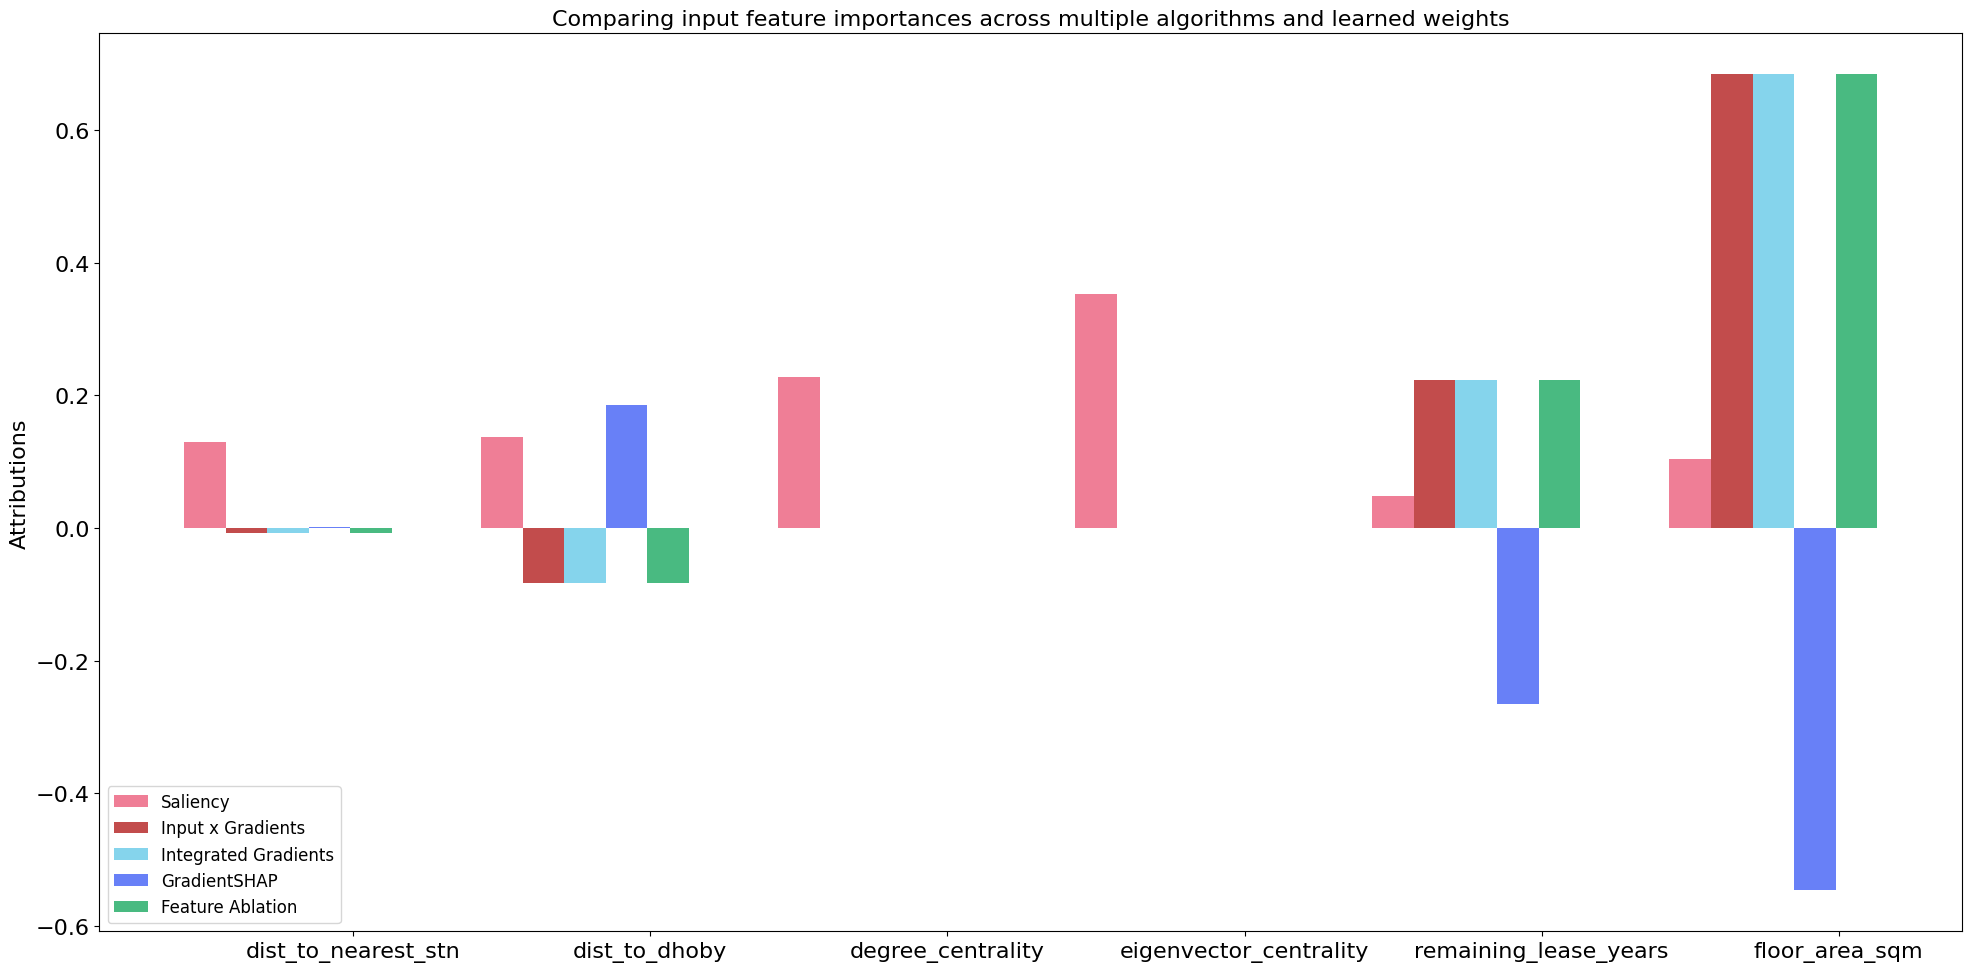

In [54]:
import matplotlib.pyplot as plt

# prepare attributions for visualization

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: df_train.drop(target, axis=1).columns[idx], x_axis_data))

saliency_attr_test_sum = saliency_attr_test.detach().numpy().sum(0)
saliency_attr_test_norm_sum = saliency_attr_test_sum / np.linalg.norm(saliency_attr_test_sum, ord=1)

inputxgradient_attr_test_sum = inputxgradient_attr_test.detach().numpy().sum(0)
inputxgradient_attr_test_norm_sum = inputxgradient_attr_test_sum / np.linalg.norm(inputxgradient_attr_test_sum, ord=1)

integratedgradients_attr_test_sum = integratedgradients_attr_test.detach().numpy().sum(0)
integratedgradients_attr_test_norm_sum = integratedgradients_attr_test_sum / np.linalg.norm(integratedgradients_attr_test_sum, ord=1)

gradientshap_attr_test_sum = gradientshap_attr_test.detach().numpy().sum(0)
gradientshap_attr_test_norm_sum = gradientshap_attr_test_sum / np.linalg.norm(gradientshap_attr_test_sum, ord=1)

featureablation_attr_test_sum = featureablation_attr_test.detach().numpy().sum(0)
featureablation_attr_test_norm_sum = featureablation_attr_test_sum / np.linalg.norm(featureablation_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, saliency_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, inputxgradient_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integratedgradients_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradientshap_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, featureablation_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

> Train a separate model with the same configuration but now standardise the features via **StandardScaler** (fit to training set, then transform all). State your observations with respect to GradientShap and explain why it has occurred.
(Hint: Many gradient-based approaches depend on a baseline, which is an important choice to be made. Check the default baseline settings carefully.)


In [55]:
# TODO: Enter your code here
from sklearn.preprocessing import StandardScaler

# perform scaling
scaler = StandardScaler()

# similar to previous questions, apply fit_transform to the train set
X_train_scaled = scaler.fit_transform(X_train)
# tensorize scaled input features
X_train_scaled = torch.tensor(X_train_scaled).float()

# similar to previous questions, apply transform to the train set
X_test_scaled = scaler.transform(X_test)
# tensorize scaled target labels
X_test_scaled = torch.tensor(X_test_scaled).float()

tensordataset_train_scaled = torch.utils.data.TensorDataset(X_train_scaled, y_train)
dataloader_train_scaled = torch.utils.data.DataLoader(tensordataset_train_scaled, batch_size=1024, shuffle=True)

# Create model
model_scaled = HDBPriceRegressionModel()

# Train model on scaled data
SAVED_MODEL_PATH = 'hdbpriceprediction_scaled_model.pt'
train_load_save_model(model_scaled, SAVED_MODEL_PATH)



Loading pre-trained model from: hdbpriceprediction_scaled_model.pt


In [56]:
model_scaled.eval()
outputs = model_scaled(X_test_scaled)
err = np.sqrt(sklearn.metrics.mean_squared_error(outputs.detach().numpy(), y_test.detach().numpy()))

print('model err: ', err)

model err:  520817.22


In [57]:
# Use Saliency, Input x Gradients, Integrated Gradients, GradientSHAP, Feature Ablation
saliency = Saliency(model) # https://captum.ai/api/saliency.html
inputxgradient = InputXGradient(model) # https://captum.ai/api/input_x_gradient.html
integratedgradients = IntegratedGradients(model)
gradientshap = GradientShap(model)
featureablation = FeatureAblation(model)

num_samples = 1000
saliency_attr_test = saliency.attribute(X_test[:num_samples])
inputxgradient_attr_test = inputxgradient.attribute(X_test[:num_samples])
integratedgradients_attr_test = integratedgradients.attribute(X_test[:num_samples], n_steps=50)
gradientshap_attr_test = gradientshap.attribute(X_test[:num_samples], X_train_scaled)
featureablation_attr_test = featureablation.attribute(X_test[:num_samples])

/usr/local/lib/python3.10/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


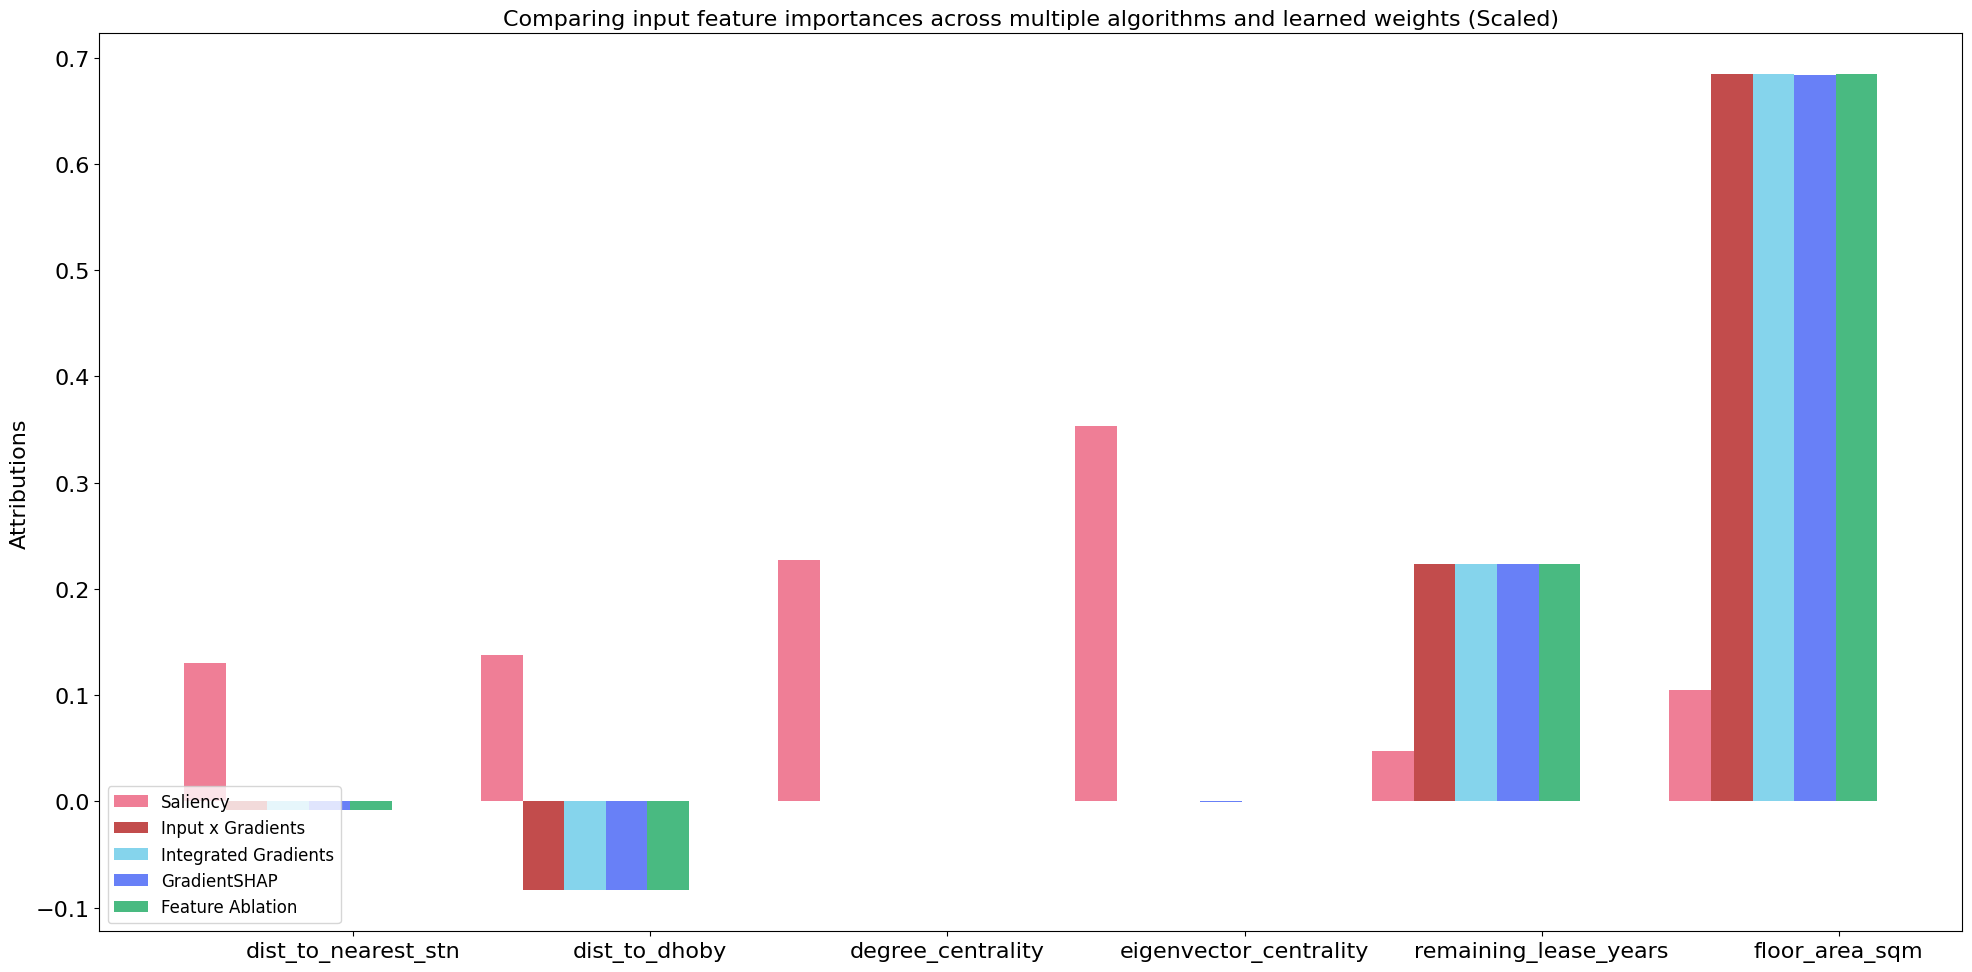

In [58]:
# prepare attributions for visualization
x_axis_data = np.arange(X_test_scaled.shape[1])
x_axis_data_labels = list(map(lambda idx: df_train.drop(target, axis=1).columns[idx], x_axis_data))

saliency_attr_test_sum = saliency_attr_test.detach().numpy().sum(0)
saliency_attr_test_norm_sum = saliency_attr_test_sum / np.linalg.norm(saliency_attr_test_sum, ord=1)

inputxgradient_attr_test_sum = inputxgradient_attr_test.detach().numpy().sum(0)
inputxgradient_attr_test_norm_sum = inputxgradient_attr_test_sum / np.linalg.norm(inputxgradient_attr_test_sum, ord=1)

integratedgradients_attr_test_sum = integratedgradients_attr_test.detach().numpy().sum(0)
integratedgradients_attr_test_norm_sum = integratedgradients_attr_test_sum / np.linalg.norm(integratedgradients_attr_test_sum, ord=1)

gradientshap_attr_test_sum = gradientshap_attr_test.detach().numpy().sum(0)
gradientshap_attr_test_norm_sum = gradientshap_attr_test_sum / np.linalg.norm(gradientshap_attr_test_sum, ord=1)

featureablation_attr_test_sum = featureablation_attr_test.detach().numpy().sum(0)
featureablation_attr_test_norm_sum = featureablation_attr_test_sum / np.linalg.norm(featureablation_attr_test_sum, ord=1)

width = 0.14
legends = ['Saliency', 'Input x Gradients', 'Integrated Gradients', 'GradientSHAP', 'Feature Ablation']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights (Scaled)')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, saliency_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, inputxgradient_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, integratedgradients_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, gradientshap_attr_test_norm_sum, width, align='center',  alpha=0.8, color='#4260f5')
ax.bar(x_axis_data + 4 * width, featureablation_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

Read https://distill.pub/2020/attribution-baselines/ to build up your understanding of Integrated Gradients (IG). Reading the sections before the section on ‘Game Theory and Missingness’ will be sufficient. Keep in mind that this article mainly focuses on classification problems. You might find the following [descriptions](https://captum.ai/docs/attribution_algorithms) and [comparisons](https://captum.ai/docs/algorithms_comparison_matrix) in Captum useful as well.


Then, answer the following questions in the context of our dataset:

> Why did Saliency produce scores similar to IG?


Based on the output generated, Saliency and Integrated Gradients produced scores that are different for all of the input features. This is because the saliency scores are only measuring the sensitivity of the model's output to changes in the input features, while the integrated gradients scores are taking into account both the sensitivity and the direction of the change.


> Why did Input x Gradients give the same attribution scores as IG?


Based on the output generated, Input x Gradients and Integrated Gradients produced scores that are the same for all of the input features as they both use gradients with respect to the input. Integrated gradients represents the integral of gradients with respect to inputs along the path from a given baseline to input, while Input X Gradient is an extension of the saliency approach, taking the gradients of the output with respect to the input and multiplying by the input feature values.
